
- Costruire un dataset di grafi di spin glass di piccola taglia (# basso di nodi) e studiare come l'apprendimento dell'energia da parte della GNN cambia al variare della connettività del grafo. Ad esempio fissando a 10 il numero di nodi, il numero di edges può essere cambiato da 9 (open spin glass chain) a 45 (fully connected spin glass) , magari provando 9, 15, 25, 45. Si costruiscono 4 dataset e si allena la stessa GNN separatamente su questi dataset in modo supervised per fare poi il confronto. (Livello medio)

In [12]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import torch.nn.functional as F
from torch_geometric.profile import get_model_size

from torch.nn import Linear
from torch_geometric.nn import global_max_pool, GraphConv
from torch_geometric.loader import DataLoader

import os 


In [13]:
# set standard dimensions for the plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14


In [14]:



def initialize_graph(L, periodic=True, n_dimensions=2):
    """
    Initialize a graph with L nodes
    """
    G = nx.Graph()
    for i in range(L):
        G.add_node(i, spin = np.random.choice([-1, 1]))
    
    for i in range(L):
        if periodic:
            for j in range(i+1, i+n_dimensions+1):
                G.add_edge(i, j % L, weight = np.random.rand()*2 -1 )
        else:
            for j in range(i+1, i+n_dimensions+1):
                if j < L:
                    G.add_edge(i, j, weight = np.random.rand()*2 -1 )
    return G
     

def plot_graph(G, pos=None):
    """
    Plot the graph with nodes colored according to their spin.
    """
    if pos is None:
        pos = nx.circular_layout(G)
    colors = ['blue' if G.nodes[i]["spin"] == 1 else 'red' for i in range(len(G.nodes) )]
    fig = plt.figure()
    nx.draw(G, pos = pos, node_color=colors, with_labels=True)
    plt.show(fig)    
    return fig
    

def calculate_energy(G, h=0 ):
    """
    Calculate the energy of the graph
    """
    E = 0
    E_h = 0
    for i, j in G.edges:
        E += G[i][j]["weight"] * G.nodes[i]["spin"] * G.nodes[j]["spin"]

    if h != 0:  # exclude the case of h = 0 to avoid floating point errors
        E_h = h * np.sum([G.nodes[i]["spin"] for i in G.nodes]) 


    return -E/2 - E_h  # divide by 2 to avoid double counting

# create a dataset with the energy as label
def create_dataset(n_nodes=10, h=0, periodic= True, n_dimensions=1, n_samples=1000):
    dataset = []
    graphs = []

    for i in range(n_samples):
        G = initialize_graph(n_nodes, periodic=periodic, n_dimensions=n_dimensions)
        X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)

        graphs.append(G)
        dataset.append(
            Data(x = X, 
                edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long),
                edge_weight = torch.tensor([G[i][j]["weight"] for i, j in G.edges], dtype=torch.float),
                y = torch.tensor([calculate_energy(G, h)], dtype=torch.float) ) )   

    return dataset, graphs

In [15]:
# GNN model

class GNN(torch.nn.Module):
    def __init__(self,hidden_channels_1=16, hidden_channels_2=16, hidden_channels_3=16,hidden_channels_4 = 16, hidden_linear=16,
                 lr = 1e-5, weight_decay=1e-3, dropout=0.5, num_node_features=1, num_classes=1):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(num_node_features,hidden_channels_1)
        self.conv2 = GraphConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GraphConv(hidden_channels_2, hidden_channels_3)
        self.conv4 = GraphConv(hidden_channels_3, hidden_channels_4)

        self.pool = global_max_pool

        self.linear1 = Linear(hidden_channels_4, hidden_linear)
        self.linear2 = Linear(hidden_linear, num_classes)

        

        self.dropout = torch.nn.Dropout(dropout)

        # we should consider also batch normalization in case of overfitting



        # Optimizer:
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Loss function:
        self.criterion = torch.nn.MSELoss()

        
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv2(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv4(x, edge_index, edge_weight))

        x = self.pool(x, data.batch) # [n_nodes*n_graph_of_the_batch, n_features] -> [n_graph_of_the_batch, n_features]

        #x = torch.flatten(x) # not needed since we are using global_max_pool
        #print(x.shape)
        x = self.dropout(x)
        x = F.leaky_relu(self.linear1(x))
        out = self.linear2(x)

        return out
    

    
    def train_step(self, data):
        # Reset gradients
        self.optimizer.zero_grad()
        # Passing the node features and the connection info
        prediction = self.forward(data)
        # reshape the prediction to match the shape of the target
        prediction = prediction.view(data.y.shape)
        # Calculating the loss and gradients
        loss = self.criterion(prediction, data.y)
        #print("prediction:",prediction.shape)
        #print("data.y:",data.y.shape)
        loss.backward()
        # Update using the gradients
        self.optimizer.step()
        
        return loss.item()
    

In [16]:
def plot_loss( train_losses, test_losses):
    fig = plt.figure()
    epoch = range(1, len(train_losses)+1)
    plt.plot(epoch, train_losses, label='Training Loss')
    plt.plot(epoch, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig


def train_model(model, train_loader, test_loader, num_epochs, patience = 5, model_name='best_model', verbose = True, device= None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # parameters for patience
    best_loss = np.inf
    patience_counter = 0


    epochs = range(1, num_epochs+1)
    train_losses, test_losses = [], []
    
    print('Training ...')

    for epoch in epochs:
        loss_per_epoch = []
        test_loss_per_epoch = []

        for i, mini_batch in enumerate(train_loader):
            mini_batch.to(device)
            train_loss = model.train_step(mini_batch)
            loss_per_epoch.append(train_loss)

        train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))


        with torch.no_grad():
            """Evaluate the model on test set"""
            for i, mini_batch in enumerate(test_loader):
                mini_batch.to(device)
                prediction = model.forward(mini_batch)
                prediction.to('cpu')
                test_loss = model.criterion(prediction, mini_batch.y).item()
                test_loss_per_epoch.append(test_loss)
            test_losses.append(sum(test_loss_per_epoch)/len(test_loss_per_epoch))
            
            if test_losses[-1] < best_loss:
                best_loss = test_losses[-1]
                torch.save(model.state_dict(), model_name + '/model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        if verbose:
            print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Test Loss {round(test_losses[-1], 5)}")


    return  train_losses, test_losses

In [17]:
# set the model name based on the values
def set_model_name(n_nodes, n_dimensions, h, periodic,n_samples, hidden_channels_1,
                    hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear,
                    lr, weight_decay, dropout, epochs):
    return f"model_{n_nodes}_{n_dimensions}_{h}_{periodic}_{n_samples}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{hidden_channels_4}_{hidden_linear}_{lr}_{weight_decay}_{dropout}_{epochs}"


# translate the model name into values
def print_values_from_model_name(model_name, print_values=True, return_dict = False): 
    values = model_name.split('_')
    # create a dictionary to store the values 
    dict = {"n_nodes": values[1], "n_dimensions": values[2], "h": values[3], "periodic": values[4], "n_samples": values[5],
            "hidden_channels_1": values[6], "hidden_channels_2": values[7], "hidden_channels_3": values[8], "hidden_channels_4": values[9], "hidden_linear": values[10],
            "lr": values[11], "weight_decay": values[12], "dropout": values[13], "epochs": values[14]}
    if print_values:
        for key, value in dict.items():
            print(f"{key}: {value}")
    if return_dict:
        return dict
    
    

def test_trained_model(model_name, test_loader, device = None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    values = print_values_from_model_name(model_name, print_values=False, return_dict=True)

    trained_model = GNN(hidden_channels_1= int(values["hidden_channels_1"]),
                hidden_channels_2= int(values["hidden_channels_2"]),
                hidden_channels_3= int(values["hidden_channels_3"]),
                hidden_channels_4= int(values["hidden_channels_4"]),
                hidden_linear= int(values["hidden_linear"]),
                lr= float(values["lr"]), weight_decay= float(values["weight_decay"]), dropout= float(values["dropout"]))
    
    trained_model.load_state_dict(torch.load(model_name + '/model.pth'))
    trained_model.to(device)

    fig = plt.figure()
    with torch.no_grad():
        predictions = []
        true_values = []
        for i, mini_batch in enumerate(test_loader):
            mini_batch.to(device)
            prediction = trained_model.forward(mini_batch)
            predictions.append(prediction.item())
            true_values.append(mini_batch.y.item())
        
        # save the mean squared error
        mse = np.mean((np.array(predictions) - np.array(true_values))**2)
       
        plt.scatter(true_values, predictions)
        plt.plot(true_values, true_values, color='red')
        plt.xlabel('True energy')
        plt.ylabel('Predicted energy')
        plt.title('Predicted vs True energy')
    
        at = AnchoredText(f"MSE: {np.round(mse,2)}", frameon=True, loc='upper left')
        plt.gca().add_artist(at)

        # plot a box similar to the legend to show the MSE
        plt.grid(True)
        plt.show()
    
    

    return fig, mse


In [18]:
# set the device and a random seed
torch.manual_seed(1022000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: ', device)

# set the palette
palette = sns.color_palette("coolwarm", as_cmap=True)

Device:  cuda


In [19]:
# set standard parameters for the model

# parameters for the dataset
n_nodes = 10
h = 0
n_samples = 1000

# parameters for the model
num_epochs = 30
batch_size = 1
lr = 1e-4
weight_decay = 1e-4
dropout = 0.4
patience = 15

# parameters for the layers
hidden_channels_1 = 16
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_channels_4 = 64
hidden_linear = 32

In [20]:
# create the model
starting_model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

# Model size and number of parameters of the model:
print(44 * '-')
print("Model:")
print("Model size (bytes):\t\t  ", get_model_size(starting_model))
print("Number of parameters:\t\t  ", sum(p.numel() for p in starting_model.parameters()))
print(44 * '-')


--------------------------------------------
Model:
Model size (bytes):		   43862
Number of parameters:		   9457
--------------------------------------------


In [21]:
# prepare lists to store the results
list_dimensions = [1,2,3,4,5]
list_periodic = [False, True]
list_datasets = []
list_graphs = []
list_n_connections = []
list_model_names = []
list_train_losses = []
list_test_losses = []
list_fig_losses = []
list_fig_tests = []
list_mse = []

n_dimensions: 1, periodic: False, number of connections: 9


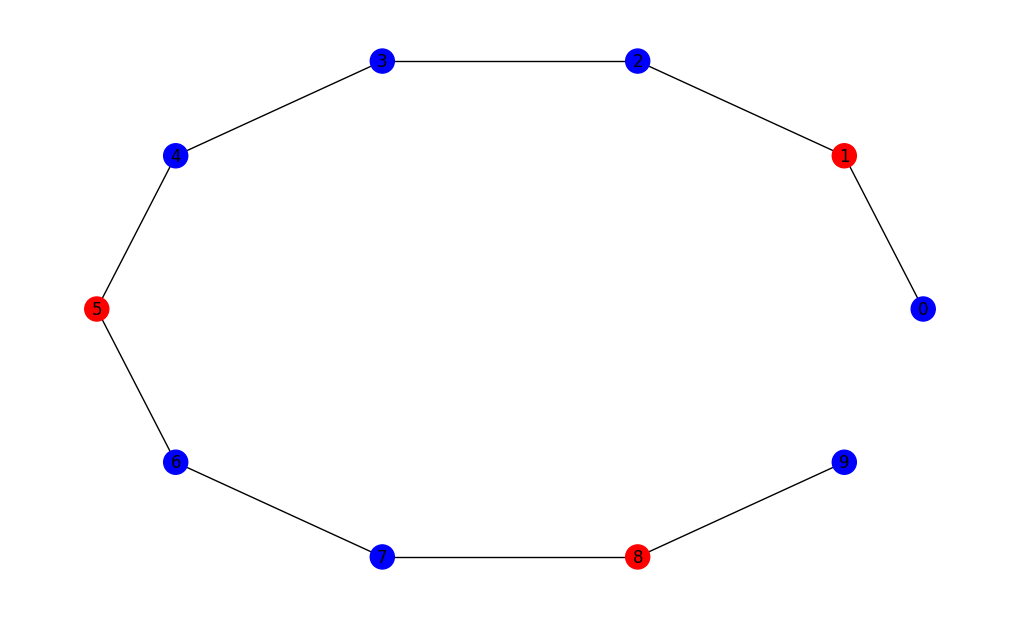

Training ...
Ep 1 	| Loss 0.70537 	| Test Loss 0.78843
Ep 2 	| Loss 0.6681 	| Test Loss 0.69803
Ep 3 	| Loss 0.54367 	| Test Loss 0.4984
Ep 4 	| Loss 0.38067 	| Test Loss 0.34783
Ep 5 	| Loss 0.29352 	| Test Loss 0.31354
Ep 6 	| Loss 0.26759 	| Test Loss 0.25766
Ep 7 	| Loss 0.21526 	| Test Loss 0.25608
Ep 8 	| Loss 0.2139 	| Test Loss 0.20321
Ep 9 	| Loss 0.21111 	| Test Loss 0.20542
Ep 10 	| Loss 0.18454 	| Test Loss 0.1985
Ep 11 	| Loss 0.1898 	| Test Loss 0.21728
Ep 12 	| Loss 0.18727 	| Test Loss 0.20838
Ep 13 	| Loss 0.18443 	| Test Loss 0.1694
Ep 14 	| Loss 0.17107 	| Test Loss 0.19054
Ep 15 	| Loss 0.18109 	| Test Loss 0.1881
Ep 16 	| Loss 0.15774 	| Test Loss 0.17754
Ep 17 	| Loss 0.16931 	| Test Loss 0.2163
Ep 18 	| Loss 0.1704 	| Test Loss 0.18738
Ep 19 	| Loss 0.16119 	| Test Loss 0.17191
Ep 20 	| Loss 0.16666 	| Test Loss 0.17569
Ep 21 	| Loss 0.15394 	| Test Loss 0.16053
Ep 22 	| Loss 0.15644 	| Test Loss 0.19382
Ep 23 	| Loss 0.15255 	| Test Loss 0.17197
Ep 24 	| Loss 0.

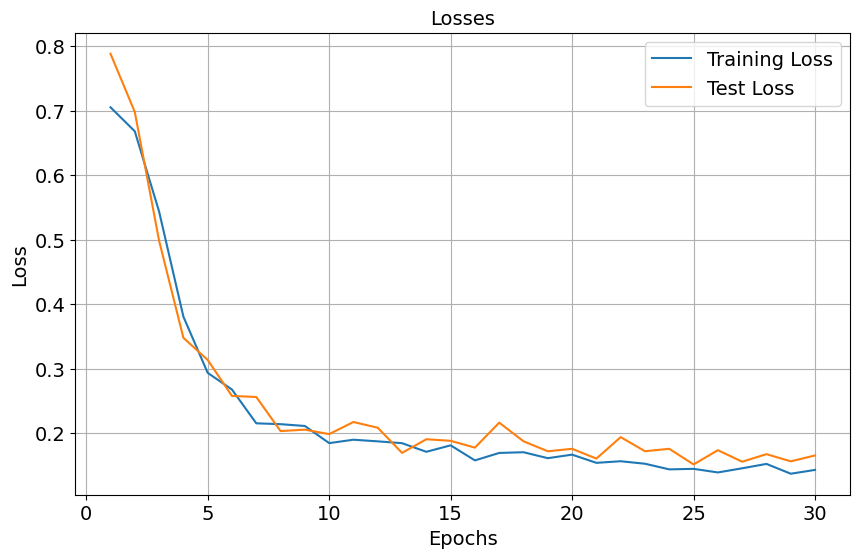

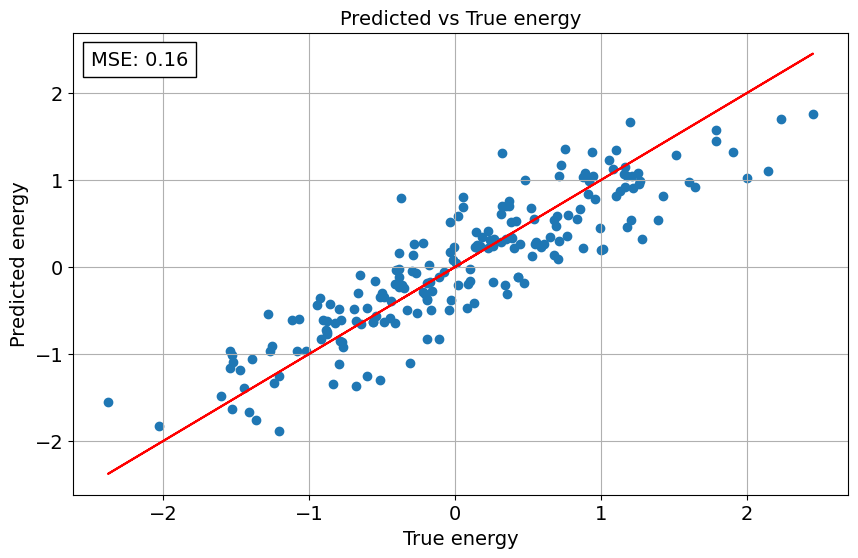

--------------------------------------------


n_dimensions: 1, periodic: True, number of connections: 10


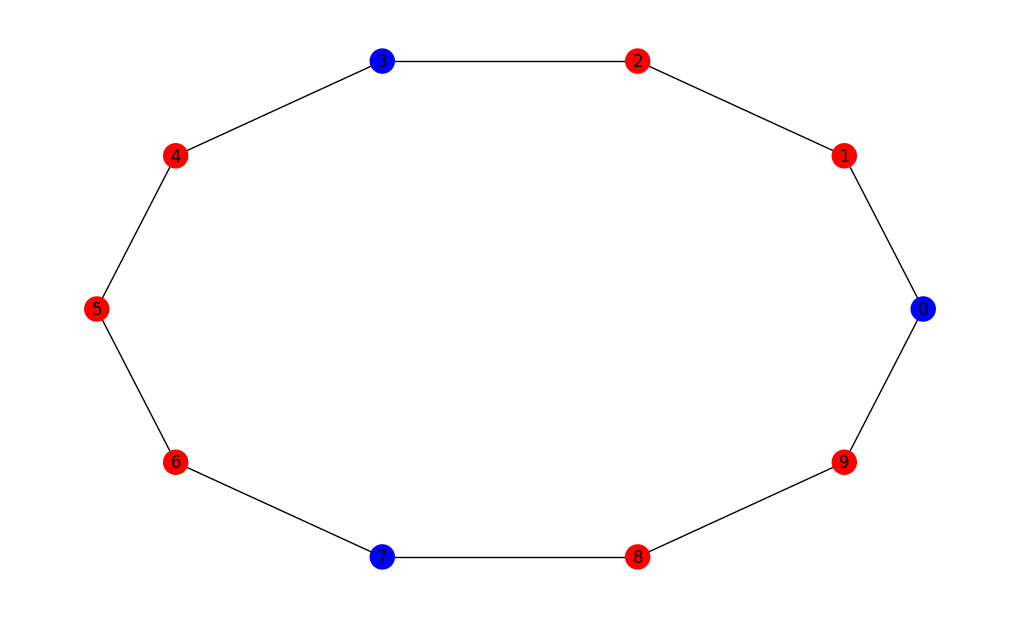

Training ...
Ep 1 	| Loss 0.78206 	| Test Loss 0.86936
Ep 2 	| Loss 0.7321 	| Test Loss 0.76358
Ep 3 	| Loss 0.60101 	| Test Loss 0.58025
Ep 4 	| Loss 0.42004 	| Test Loss 0.41915
Ep 5 	| Loss 0.31649 	| Test Loss 0.3525
Ep 6 	| Loss 0.28277 	| Test Loss 0.29132
Ep 7 	| Loss 0.25168 	| Test Loss 0.27609
Ep 8 	| Loss 0.24668 	| Test Loss 0.25344
Ep 9 	| Loss 0.23463 	| Test Loss 0.24159
Ep 10 	| Loss 0.2221 	| Test Loss 0.28325
Ep 11 	| Loss 0.20941 	| Test Loss 0.23449
Ep 12 	| Loss 0.21674 	| Test Loss 0.22319
Ep 13 	| Loss 0.21022 	| Test Loss 0.20659
Ep 14 	| Loss 0.20136 	| Test Loss 0.1807
Ep 15 	| Loss 0.18039 	| Test Loss 0.25609
Ep 16 	| Loss 0.18551 	| Test Loss 0.21345
Ep 17 	| Loss 0.17667 	| Test Loss 0.19503
Ep 18 	| Loss 0.18501 	| Test Loss 0.21717
Ep 19 	| Loss 0.1698 	| Test Loss 0.20905
Ep 20 	| Loss 0.18639 	| Test Loss 0.17418
Ep 21 	| Loss 0.16196 	| Test Loss 0.2098
Ep 22 	| Loss 0.15194 	| Test Loss 0.16403
Ep 23 	| Loss 0.1564 	| Test Loss 0.22066
Ep 24 	| Loss 

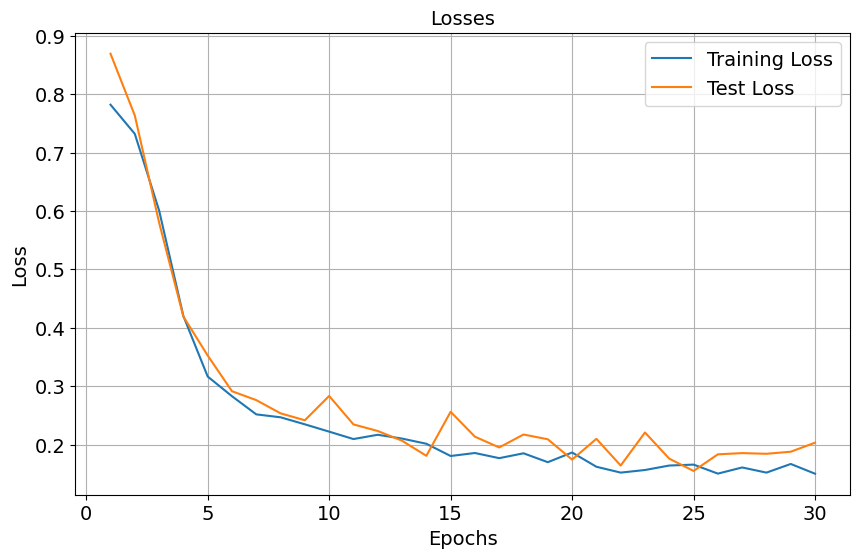

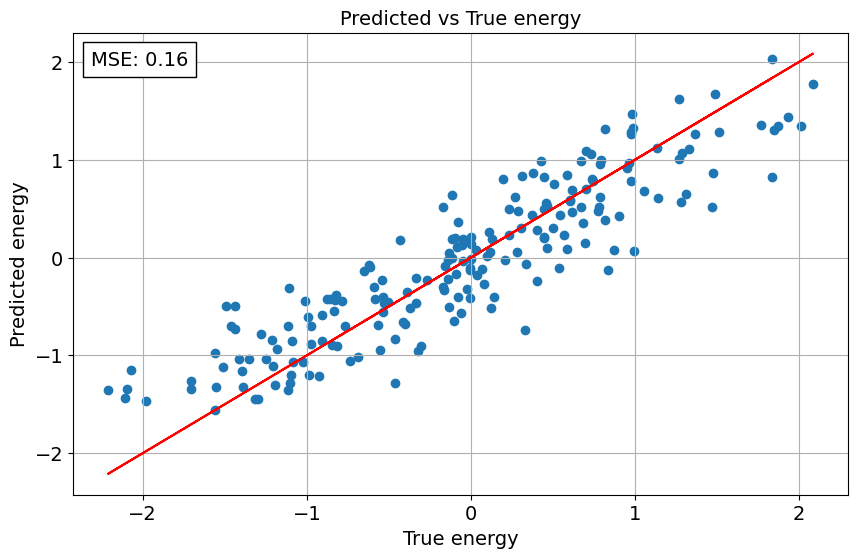

--------------------------------------------


n_dimensions: 2, periodic: False, number of connections: 17


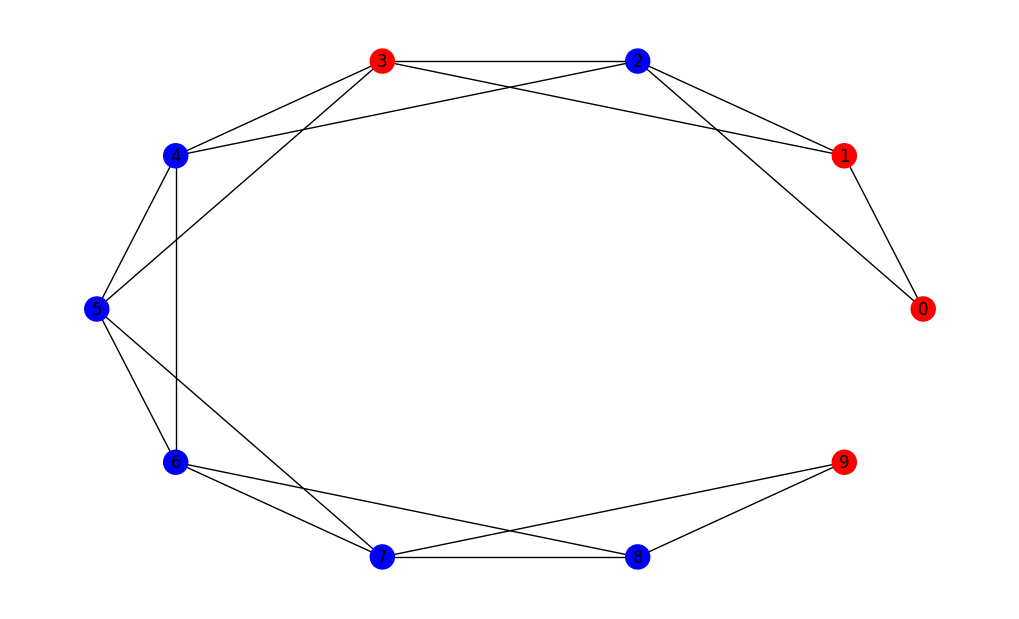

Training ...
Ep 1 	| Loss 1.29405 	| Test Loss 1.43348
Ep 2 	| Loss 1.18209 	| Test Loss 1.29734
Ep 3 	| Loss 0.96527 	| Test Loss 1.04082
Ep 4 	| Loss 0.72775 	| Test Loss 0.84602
Ep 5 	| Loss 0.60998 	| Test Loss 0.69232
Ep 6 	| Loss 0.50955 	| Test Loss 0.60914
Ep 7 	| Loss 0.47498 	| Test Loss 0.54317
Ep 8 	| Loss 0.42092 	| Test Loss 0.46692
Ep 9 	| Loss 0.39152 	| Test Loss 0.41481
Ep 10 	| Loss 0.36254 	| Test Loss 0.36416
Ep 11 	| Loss 0.36501 	| Test Loss 0.37646
Ep 12 	| Loss 0.3399 	| Test Loss 0.35845
Ep 13 	| Loss 0.3157 	| Test Loss 0.3615
Ep 14 	| Loss 0.28904 	| Test Loss 0.33271
Ep 15 	| Loss 0.28988 	| Test Loss 0.30049
Ep 16 	| Loss 0.264 	| Test Loss 0.3385
Ep 17 	| Loss 0.29435 	| Test Loss 0.33338
Ep 18 	| Loss 0.24866 	| Test Loss 0.33482
Ep 19 	| Loss 0.24426 	| Test Loss 0.30401
Ep 20 	| Loss 0.25933 	| Test Loss 0.26588
Ep 21 	| Loss 0.25873 	| Test Loss 0.36626
Ep 22 	| Loss 0.25883 	| Test Loss 0.32601
Ep 23 	| Loss 0.25744 	| Test Loss 0.30707
Ep 24 	| Loss

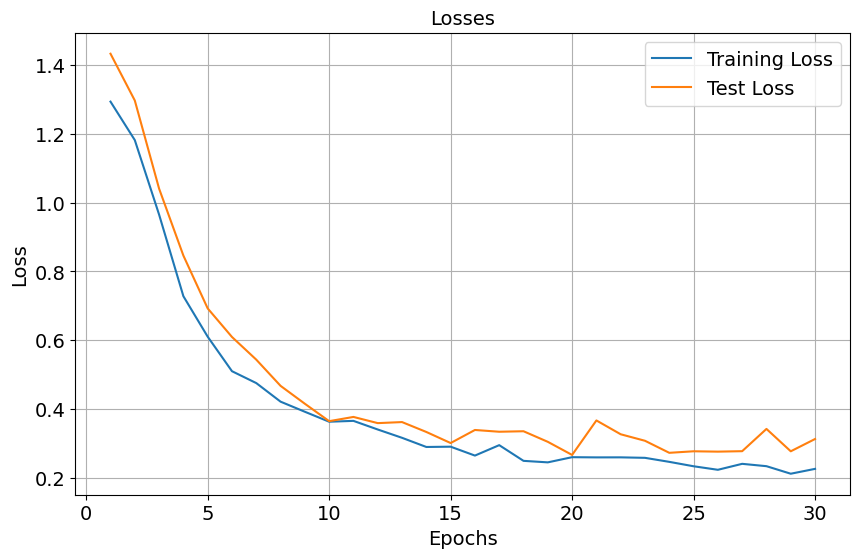

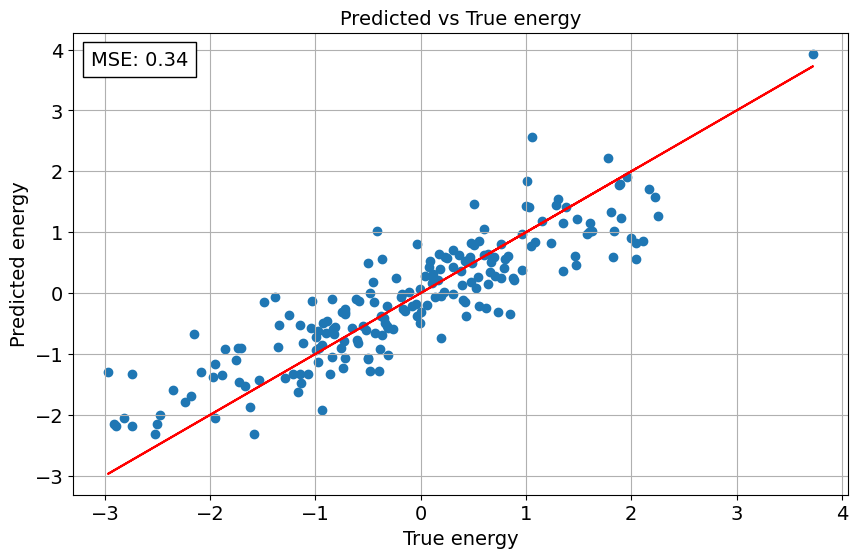

--------------------------------------------


n_dimensions: 2, periodic: True, number of connections: 20


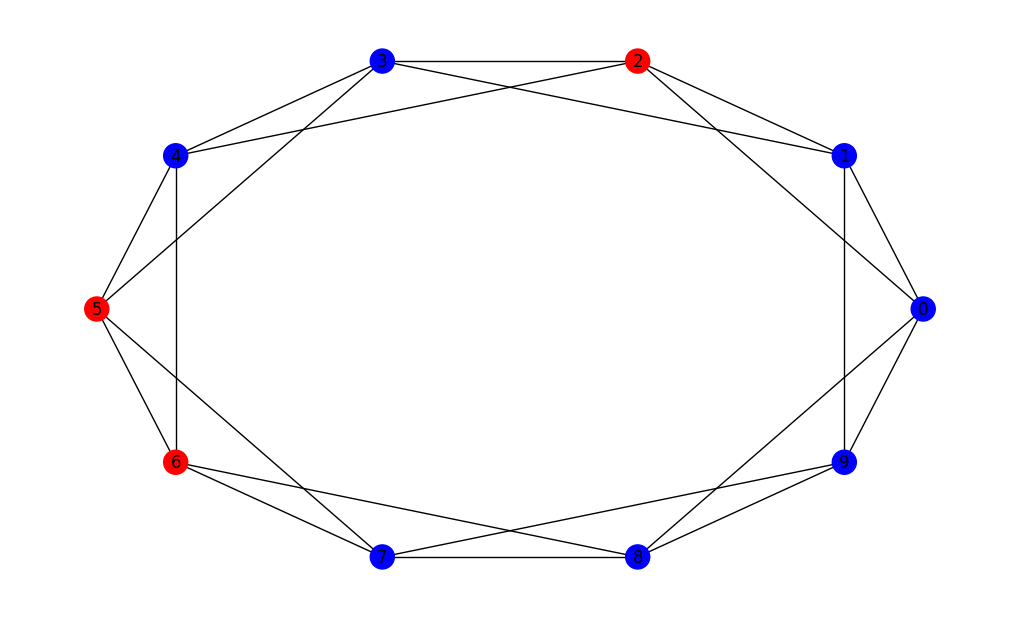

Training ...
Ep 1 	| Loss 1.68916 	| Test Loss 1.45429
Ep 2 	| Loss 1.64887 	| Test Loss 1.404
Ep 3 	| Loss 1.50092 	| Test Loss 1.20358
Ep 4 	| Loss 1.13877 	| Test Loss 0.88705
Ep 5 	| Loss 0.83881 	| Test Loss 0.63218
Ep 6 	| Loss 0.68285 	| Test Loss 0.59988
Ep 7 	| Loss 0.63787 	| Test Loss 0.56923
Ep 8 	| Loss 0.55166 	| Test Loss 0.54059
Ep 9 	| Loss 0.52003 	| Test Loss 0.44516
Ep 10 	| Loss 0.47781 	| Test Loss 0.48177
Ep 11 	| Loss 0.45683 	| Test Loss 0.45109
Ep 12 	| Loss 0.43542 	| Test Loss 0.41655
Ep 13 	| Loss 0.42856 	| Test Loss 0.41394
Ep 14 	| Loss 0.40917 	| Test Loss 0.46474
Ep 15 	| Loss 0.38051 	| Test Loss 0.40835
Ep 16 	| Loss 0.41592 	| Test Loss 0.42118
Ep 17 	| Loss 0.38971 	| Test Loss 0.33851
Ep 18 	| Loss 0.35222 	| Test Loss 0.44988
Ep 19 	| Loss 0.36351 	| Test Loss 0.43546
Ep 20 	| Loss 0.3411 	| Test Loss 0.36363
Ep 21 	| Loss 0.35766 	| Test Loss 0.34532
Ep 22 	| Loss 0.36521 	| Test Loss 0.34828
Ep 23 	| Loss 0.34444 	| Test Loss 0.38599
Ep 24 	| L

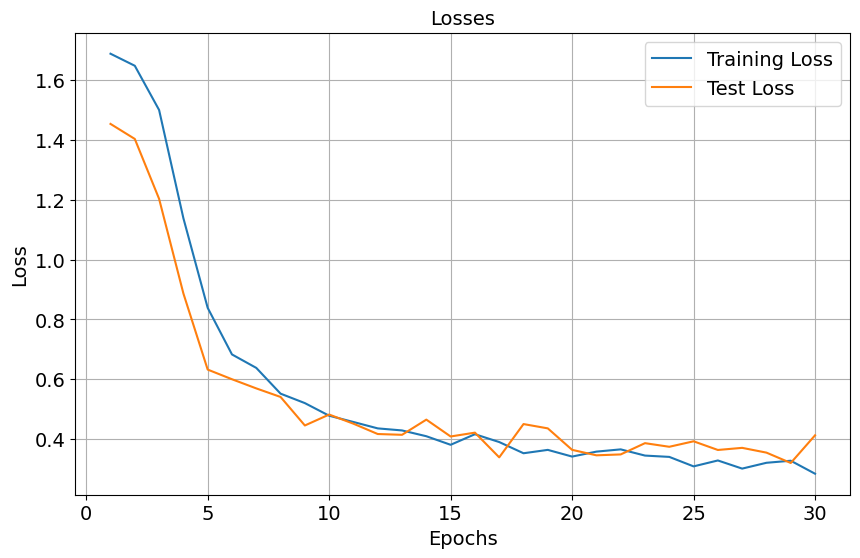

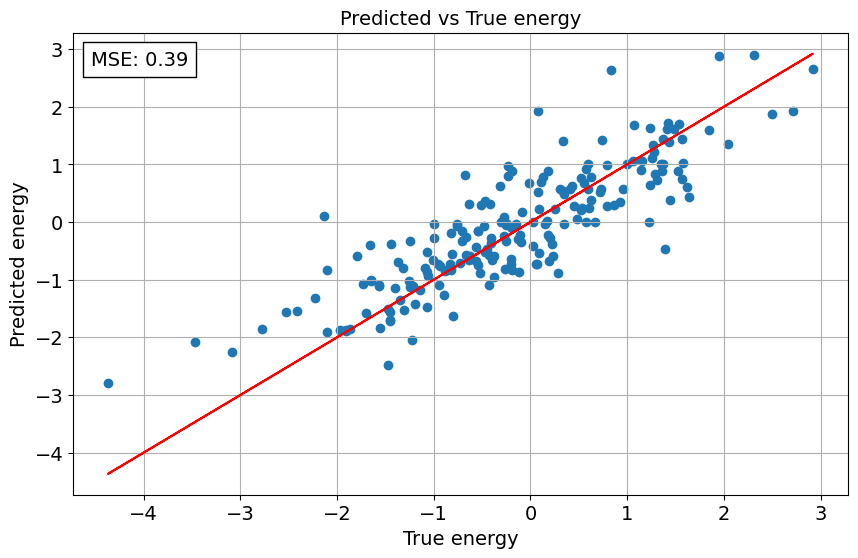

--------------------------------------------


n_dimensions: 3, periodic: False, number of connections: 24


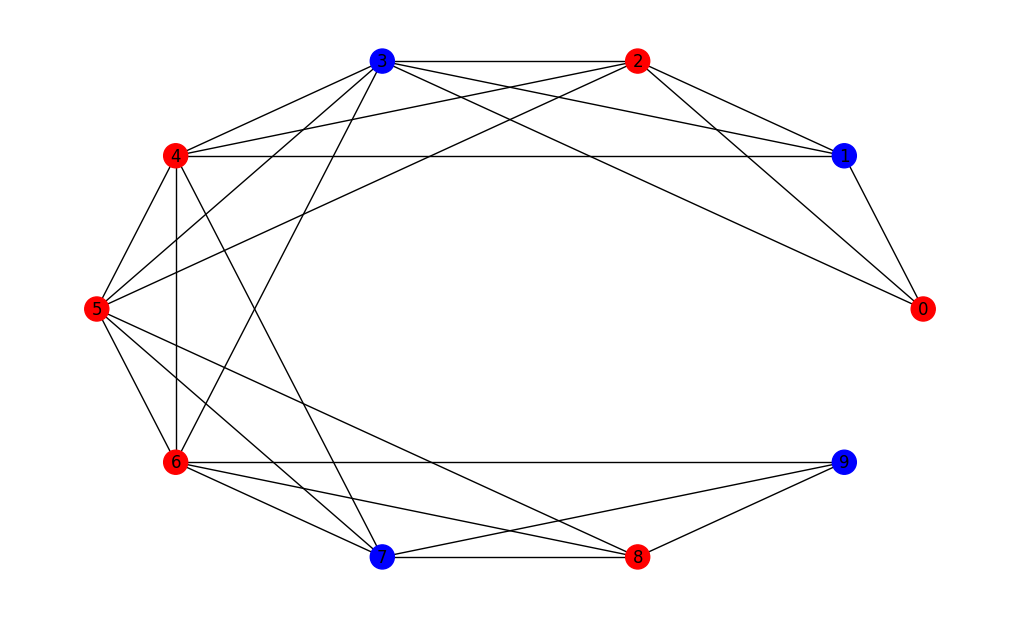

Training ...
Ep 1 	| Loss 1.97106 	| Test Loss 1.69749
Ep 2 	| Loss 1.8668 	| Test Loss 1.52526
Ep 3 	| Loss 1.63256 	| Test Loss 1.26374
Ep 4 	| Loss 1.25584 	| Test Loss 1.03757
Ep 5 	| Loss 1.01485 	| Test Loss 0.80604
Ep 6 	| Loss 0.88672 	| Test Loss 0.77442
Ep 7 	| Loss 0.73667 	| Test Loss 0.68283
Ep 8 	| Loss 0.74816 	| Test Loss 0.63038
Ep 9 	| Loss 0.64555 	| Test Loss 0.71961
Ep 10 	| Loss 0.64622 	| Test Loss 0.58745
Ep 11 	| Loss 0.6316 	| Test Loss 0.57963
Ep 12 	| Loss 0.60041 	| Test Loss 0.59947
Ep 13 	| Loss 0.56537 	| Test Loss 0.59032
Ep 14 	| Loss 0.5251 	| Test Loss 0.46168
Ep 15 	| Loss 0.56075 	| Test Loss 0.53962
Ep 16 	| Loss 0.5405 	| Test Loss 0.52142
Ep 17 	| Loss 0.5244 	| Test Loss 0.51113
Ep 18 	| Loss 0.48286 	| Test Loss 0.52762
Ep 19 	| Loss 0.48061 	| Test Loss 0.46759
Ep 20 	| Loss 0.47432 	| Test Loss 0.46727
Ep 21 	| Loss 0.46466 	| Test Loss 0.53468
Ep 22 	| Loss 0.49287 	| Test Loss 0.49982
Ep 23 	| Loss 0.46172 	| Test Loss 0.48824
Ep 24 	| Los

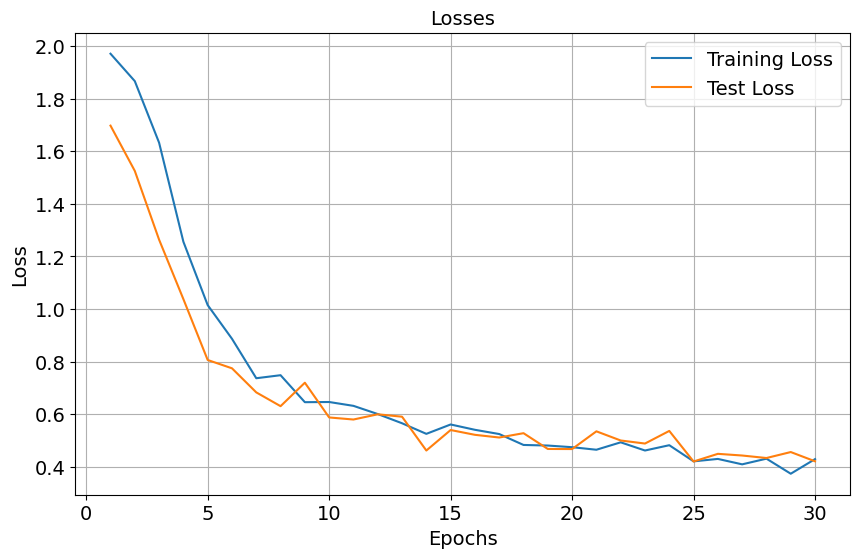

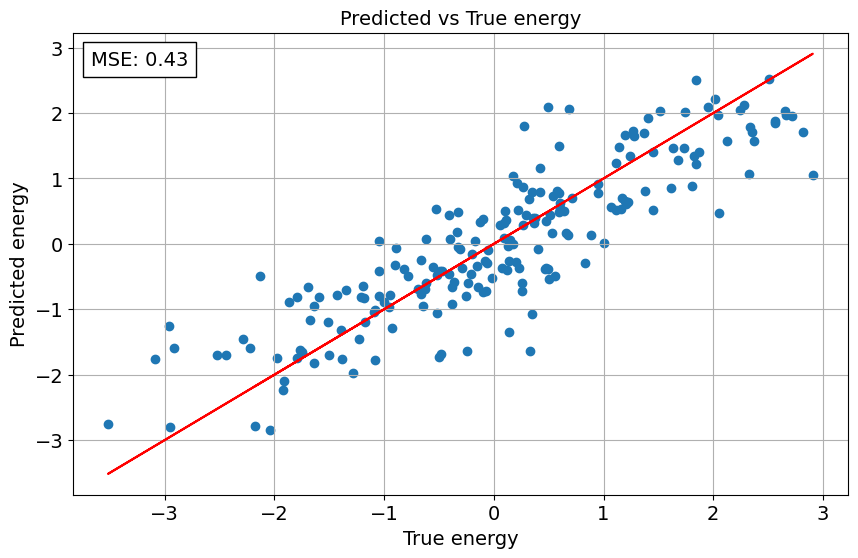

--------------------------------------------


n_dimensions: 3, periodic: True, number of connections: 30


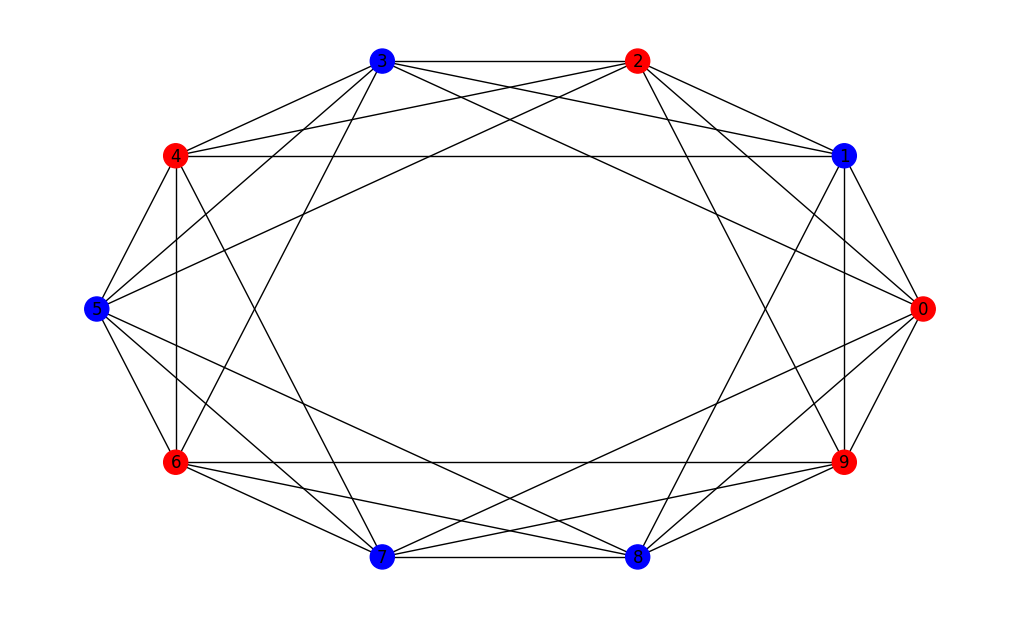

Training ...
Ep 1 	| Loss 2.36014 	| Test Loss 2.67497
Ep 2 	| Loss 2.25979 	| Test Loss 2.55212
Ep 3 	| Loss 2.12817 	| Test Loss 2.32695
Ep 4 	| Loss 1.81415 	| Test Loss 1.77575
Ep 5 	| Loss 1.42196 	| Test Loss 1.29708
Ep 6 	| Loss 1.16985 	| Test Loss 1.19485
Ep 7 	| Loss 0.94396 	| Test Loss 0.94186
Ep 8 	| Loss 0.87668 	| Test Loss 0.83994
Ep 9 	| Loss 0.80946 	| Test Loss 0.85959
Ep 10 	| Loss 0.75215 	| Test Loss 0.68609
Ep 11 	| Loss 0.66309 	| Test Loss 0.78061
Ep 12 	| Loss 0.56218 	| Test Loss 0.67915
Ep 13 	| Loss 0.5965 	| Test Loss 0.79531
Ep 14 	| Loss 0.55902 	| Test Loss 0.72066
Ep 15 	| Loss 0.54356 	| Test Loss 0.68636
Ep 16 	| Loss 0.52416 	| Test Loss 0.67988
Ep 17 	| Loss 0.52862 	| Test Loss 0.65885
Ep 18 	| Loss 0.47017 	| Test Loss 0.63821
Ep 19 	| Loss 0.48479 	| Test Loss 0.57926
Ep 20 	| Loss 0.46618 	| Test Loss 0.61937
Ep 21 	| Loss 0.4734 	| Test Loss 0.69924
Ep 22 	| Loss 0.45781 	| Test Loss 0.53125
Ep 23 	| Loss 0.45508 	| Test Loss 0.60449
Ep 24 	| 

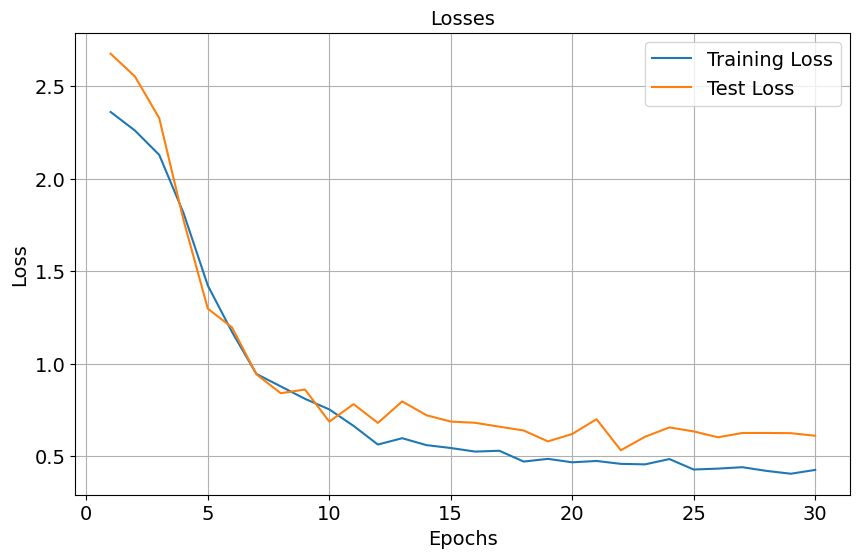

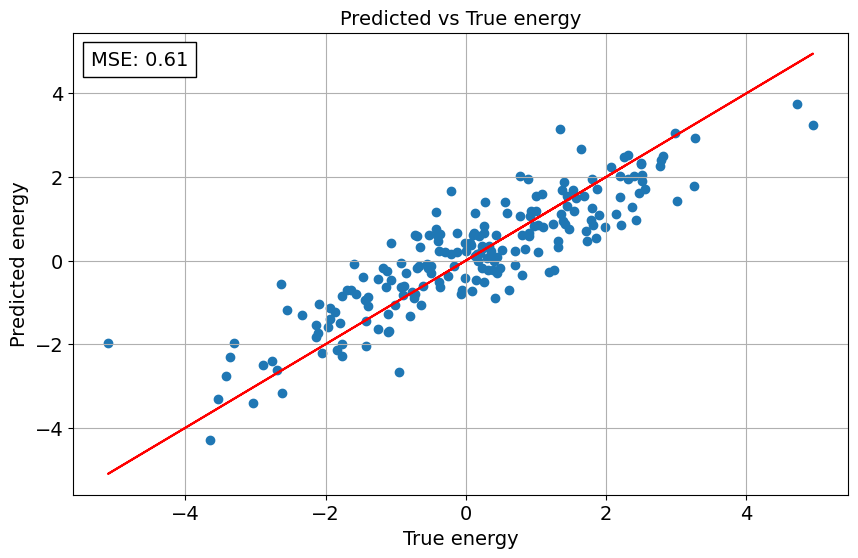

--------------------------------------------


n_dimensions: 4, periodic: False, number of connections: 30


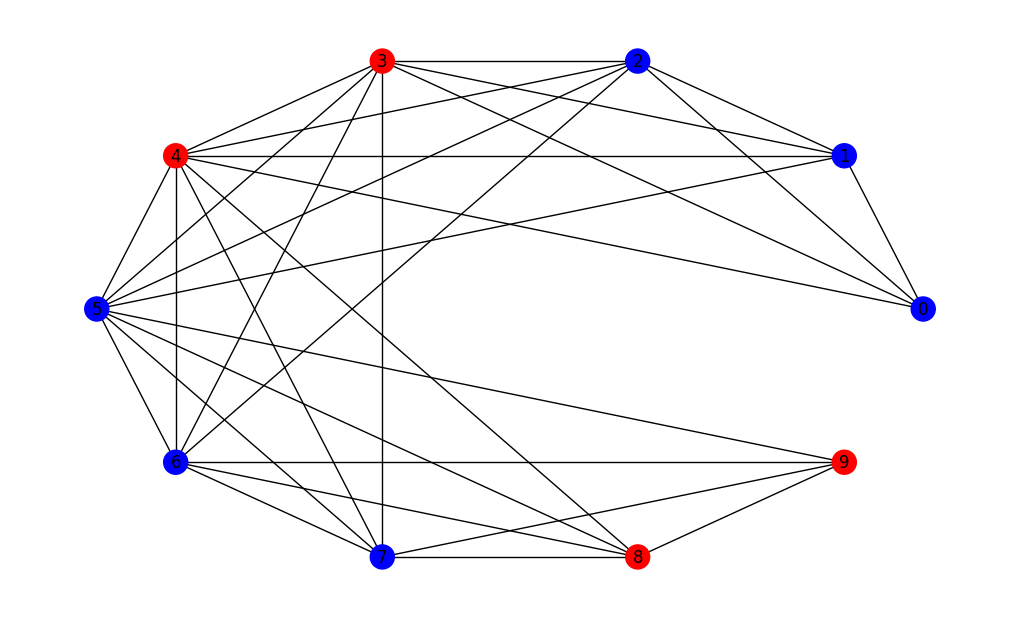

Training ...
Ep 1 	| Loss 2.36042 	| Test Loss 2.5152
Ep 2 	| Loss 2.2469 	| Test Loss 2.41139
Ep 3 	| Loss 2.09015 	| Test Loss 2.28221
Ep 4 	| Loss 1.8434 	| Test Loss 1.94607
Ep 5 	| Loss 1.51956 	| Test Loss 1.58907
Ep 6 	| Loss 1.21173 	| Test Loss 1.32881
Ep 7 	| Loss 1.05792 	| Test Loss 1.22864
Ep 8 	| Loss 0.90725 	| Test Loss 1.02228
Ep 9 	| Loss 0.80605 	| Test Loss 0.92919
Ep 10 	| Loss 0.74857 	| Test Loss 0.93106
Ep 11 	| Loss 0.68249 	| Test Loss 0.84351
Ep 12 	| Loss 0.6503 	| Test Loss 0.87928
Ep 13 	| Loss 0.60444 	| Test Loss 0.66041
Ep 14 	| Loss 0.61183 	| Test Loss 0.77557
Ep 15 	| Loss 0.61601 	| Test Loss 0.67562
Ep 16 	| Loss 0.54235 	| Test Loss 0.65348
Ep 17 	| Loss 0.5316 	| Test Loss 0.68347
Ep 18 	| Loss 0.48902 	| Test Loss 0.6186
Ep 19 	| Loss 0.49841 	| Test Loss 0.70811
Ep 20 	| Loss 0.47028 	| Test Loss 0.67164
Ep 21 	| Loss 0.48044 	| Test Loss 0.59116
Ep 22 	| Loss 0.46252 	| Test Loss 0.6046
Ep 23 	| Loss 0.44866 	| Test Loss 0.49531
Ep 24 	| Loss 

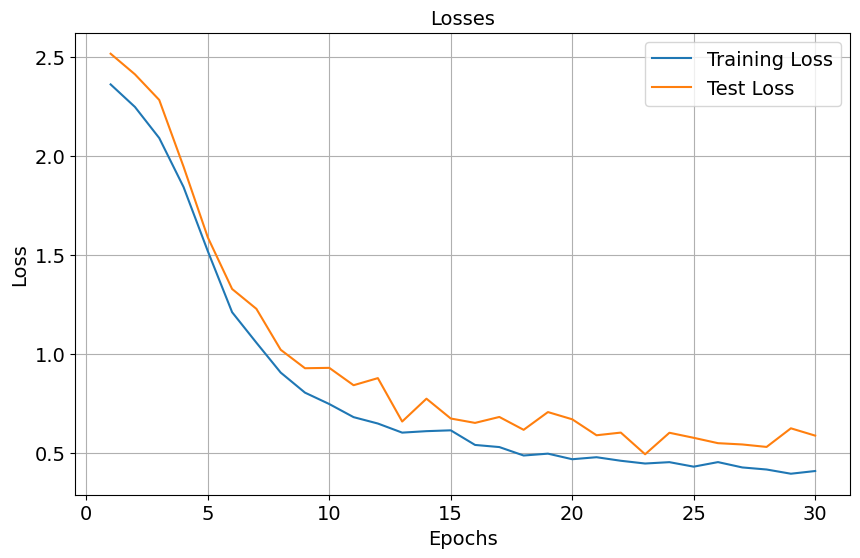

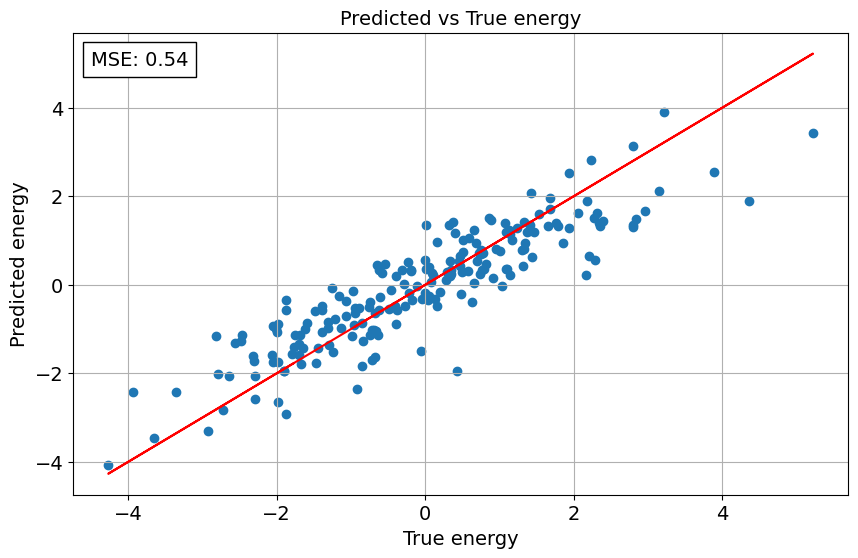

--------------------------------------------


n_dimensions: 4, periodic: True, number of connections: 40


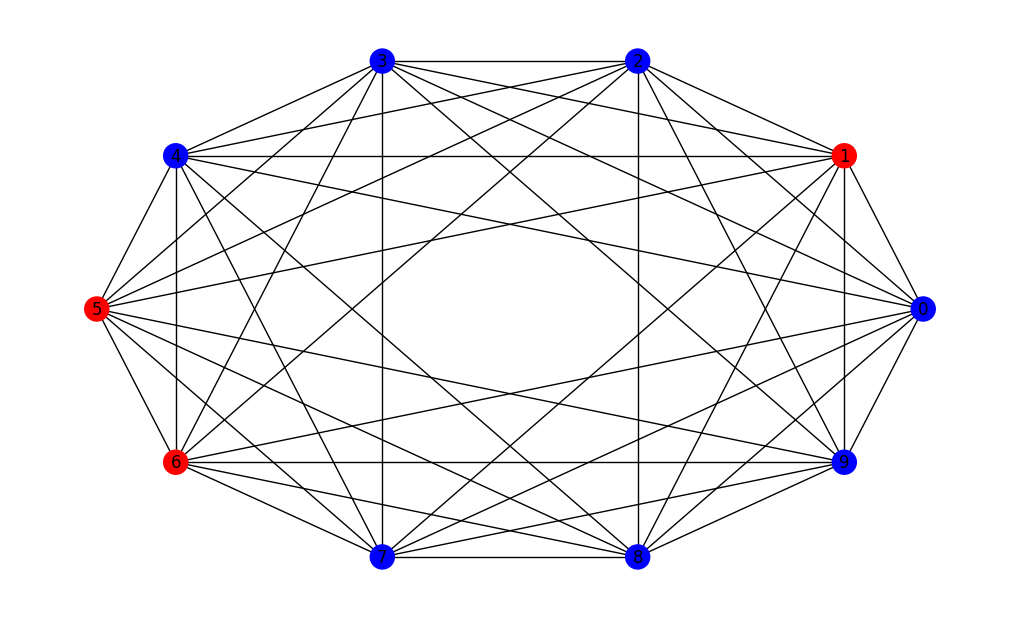

Training ...
Ep 1 	| Loss 3.09263 	| Test Loss 3.94882
Ep 2 	| Loss 3.00851 	| Test Loss 3.94941
Ep 3 	| Loss 2.92569 	| Test Loss 3.8362
Ep 4 	| Loss 2.75429 	| Test Loss 3.53524
Ep 5 	| Loss 2.40774 	| Test Loss 2.94444
Ep 6 	| Loss 2.03013 	| Test Loss 2.33322
Ep 7 	| Loss 1.7107 	| Test Loss 2.08753
Ep 8 	| Loss 1.34894 	| Test Loss 1.54682
Ep 9 	| Loss 1.20217 	| Test Loss 1.52907
Ep 10 	| Loss 1.02057 	| Test Loss 1.29253
Ep 11 	| Loss 0.98804 	| Test Loss 1.26953
Ep 12 	| Loss 0.84622 	| Test Loss 1.07569
Ep 13 	| Loss 0.82532 	| Test Loss 1.07274
Ep 14 	| Loss 0.82536 	| Test Loss 1.11009
Ep 15 	| Loss 0.72548 	| Test Loss 0.99135
Ep 16 	| Loss 0.74263 	| Test Loss 0.98305
Ep 17 	| Loss 0.70004 	| Test Loss 0.86308
Ep 18 	| Loss 0.69128 	| Test Loss 0.87042
Ep 19 	| Loss 0.6954 	| Test Loss 0.99916
Ep 20 	| Loss 0.67432 	| Test Loss 0.97654
Ep 21 	| Loss 0.68811 	| Test Loss 0.87822
Ep 22 	| Loss 0.57625 	| Test Loss 1.02061
Ep 23 	| Loss 0.59111 	| Test Loss 0.77305
Ep 24 	| L

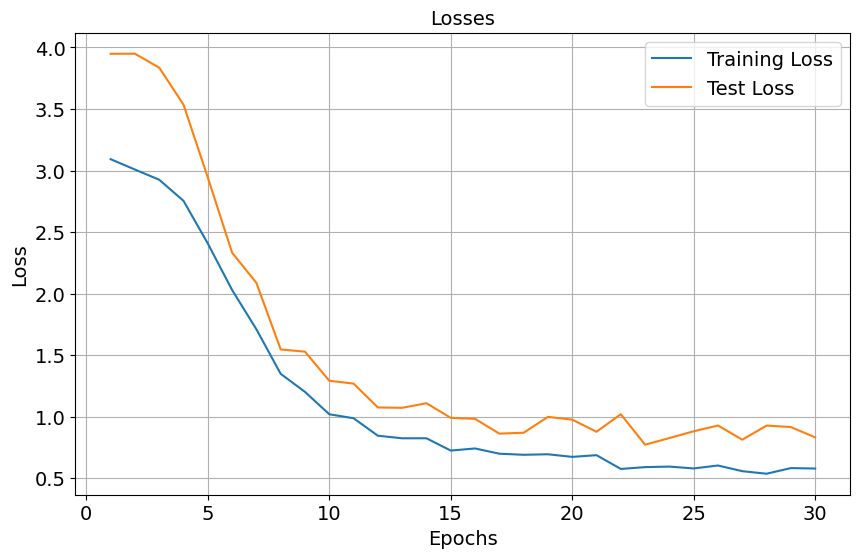

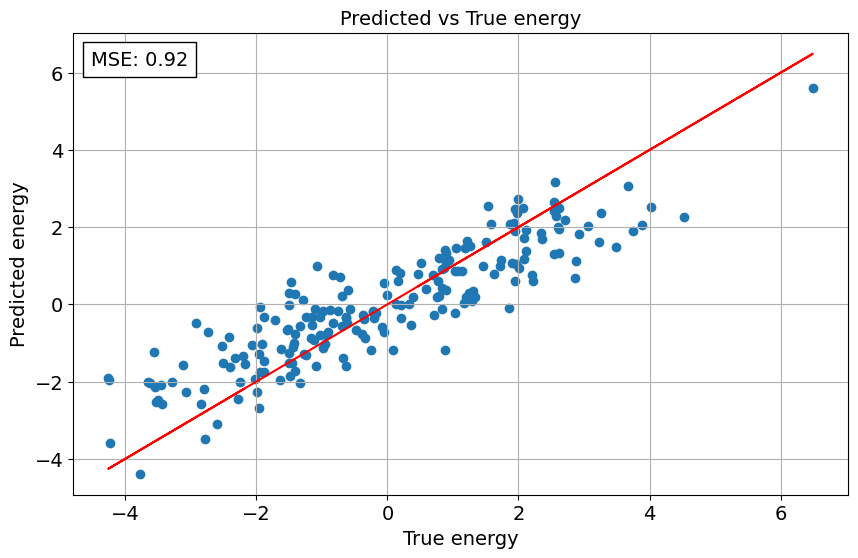

--------------------------------------------


n_dimensions: 5, periodic: False, number of connections: 35


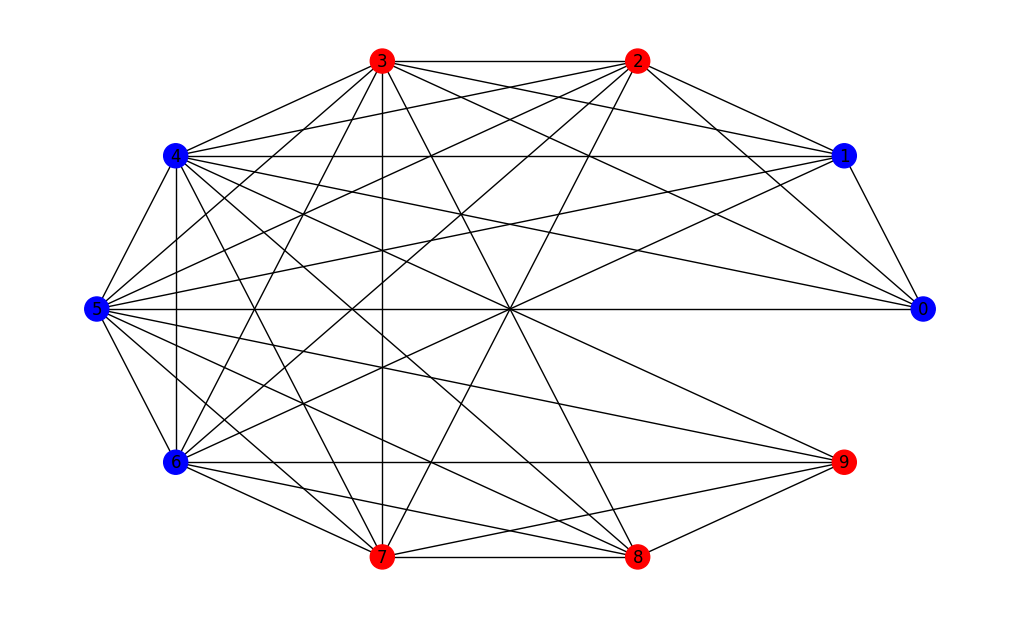

Training ...
Ep 1 	| Loss 2.74246 	| Test Loss 3.14667
Ep 2 	| Loss 2.62571 	| Test Loss 2.96347
Ep 3 	| Loss 2.33604 	| Test Loss 2.45879
Ep 4 	| Loss 1.81337 	| Test Loss 1.91244
Ep 5 	| Loss 1.38734 	| Test Loss 1.45674
Ep 6 	| Loss 1.24818 	| Test Loss 1.22835
Ep 7 	| Loss 1.01881 	| Test Loss 1.17502
Ep 8 	| Loss 0.97516 	| Test Loss 1.02185
Ep 9 	| Loss 0.85864 	| Test Loss 0.92499
Ep 10 	| Loss 0.7516 	| Test Loss 0.9088
Ep 11 	| Loss 0.75785 	| Test Loss 0.81685
Ep 12 	| Loss 0.62678 	| Test Loss 0.76581
Ep 13 	| Loss 0.66154 	| Test Loss 0.77821
Ep 14 	| Loss 0.62491 	| Test Loss 0.71515
Ep 15 	| Loss 0.61293 	| Test Loss 0.66595
Ep 16 	| Loss 0.57683 	| Test Loss 0.74757
Ep 17 	| Loss 0.55124 	| Test Loss 0.63706
Ep 18 	| Loss 0.57713 	| Test Loss 0.79369
Ep 19 	| Loss 0.5587 	| Test Loss 0.75504
Ep 20 	| Loss 0.55104 	| Test Loss 0.68028
Ep 21 	| Loss 0.46971 	| Test Loss 0.67276
Ep 22 	| Loss 0.52642 	| Test Loss 0.59197
Ep 23 	| Loss 0.49139 	| Test Loss 0.65619
Ep 24 	| L

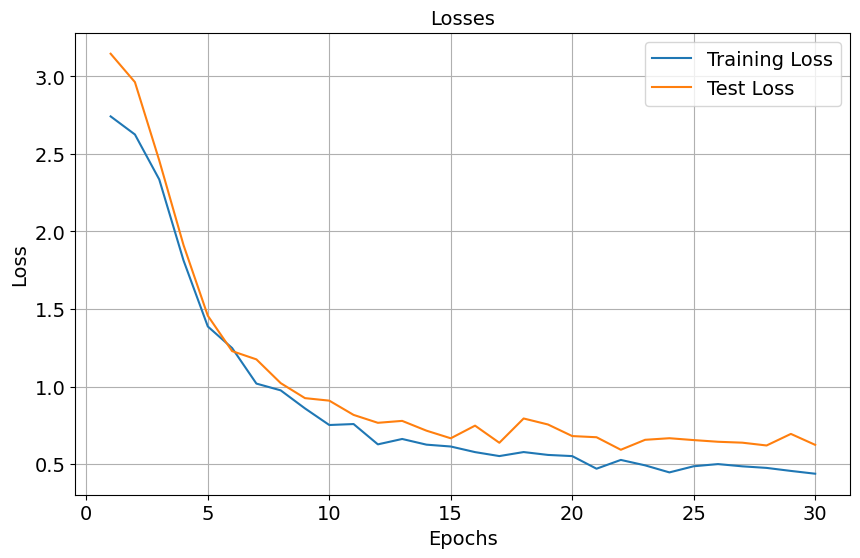

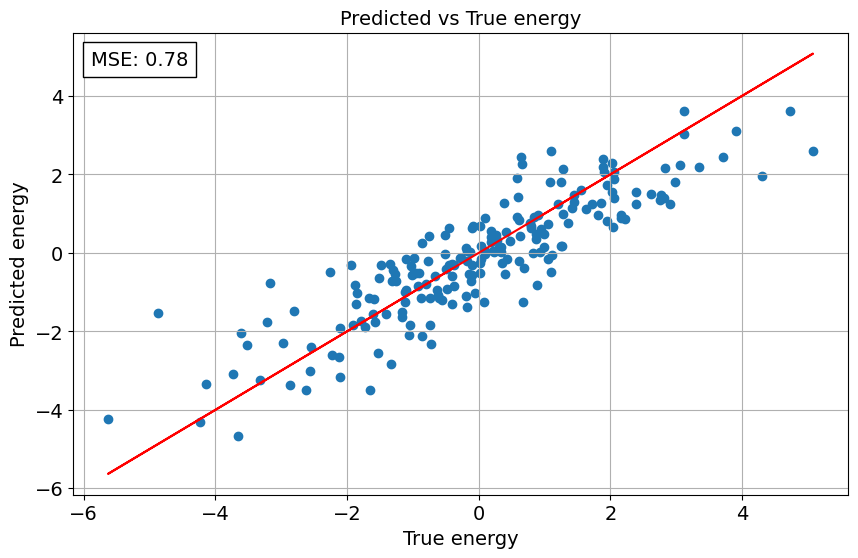

--------------------------------------------


n_dimensions: 5, periodic: True, number of connections: 45


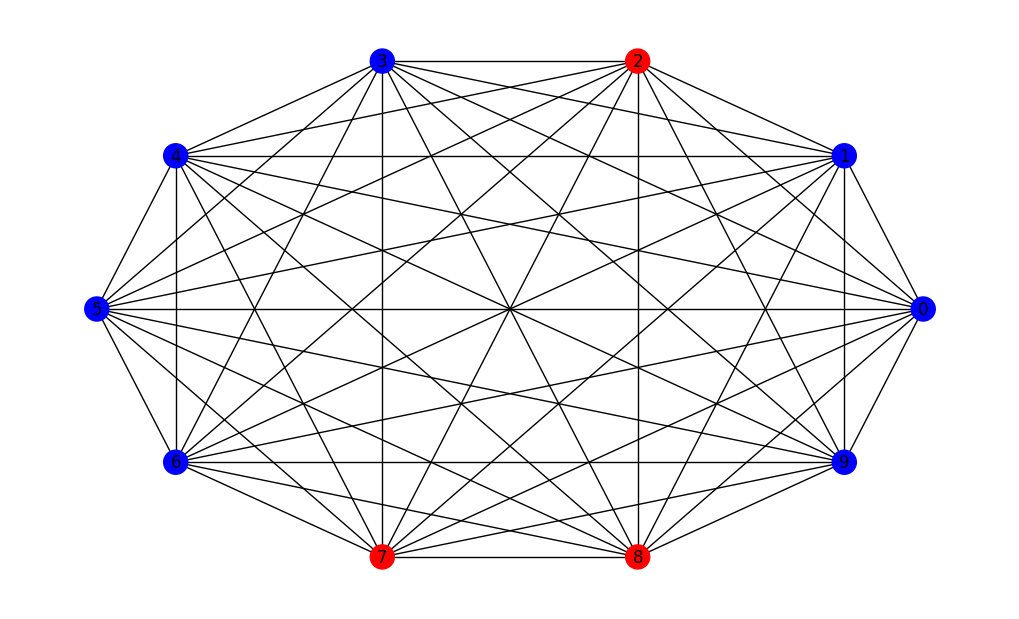

Training ...
Ep 1 	| Loss 3.57358 	| Test Loss 3.9731
Ep 2 	| Loss 3.5083 	| Test Loss 3.84035
Ep 3 	| Loss 3.33753 	| Test Loss 3.61988
Ep 4 	| Loss 3.04992 	| Test Loss 3.18603
Ep 5 	| Loss 2.56408 	| Test Loss 2.72533
Ep 6 	| Loss 2.04185 	| Test Loss 2.12009
Ep 7 	| Loss 1.80806 	| Test Loss 2.04305
Ep 8 	| Loss 1.46041 	| Test Loss 1.40719
Ep 9 	| Loss 1.29091 	| Test Loss 1.47371
Ep 10 	| Loss 1.00111 	| Test Loss 1.14458
Ep 11 	| Loss 1.00936 	| Test Loss 1.12514
Ep 12 	| Loss 0.92904 	| Test Loss 1.00716
Ep 13 	| Loss 0.89346 	| Test Loss 1.07383
Ep 14 	| Loss 0.77868 	| Test Loss 0.8819
Ep 15 	| Loss 0.837 	| Test Loss 0.95769
Ep 16 	| Loss 0.80203 	| Test Loss 0.94385
Ep 17 	| Loss 0.77035 	| Test Loss 0.93437
Ep 18 	| Loss 0.80408 	| Test Loss 0.77915
Ep 19 	| Loss 0.79472 	| Test Loss 0.78334
Ep 20 	| Loss 0.74625 	| Test Loss 0.87889
Ep 21 	| Loss 0.6999 	| Test Loss 0.86378
Ep 22 	| Loss 0.68335 	| Test Loss 0.77096
Ep 23 	| Loss 0.67659 	| Test Loss 0.80989
Ep 24 	| Loss

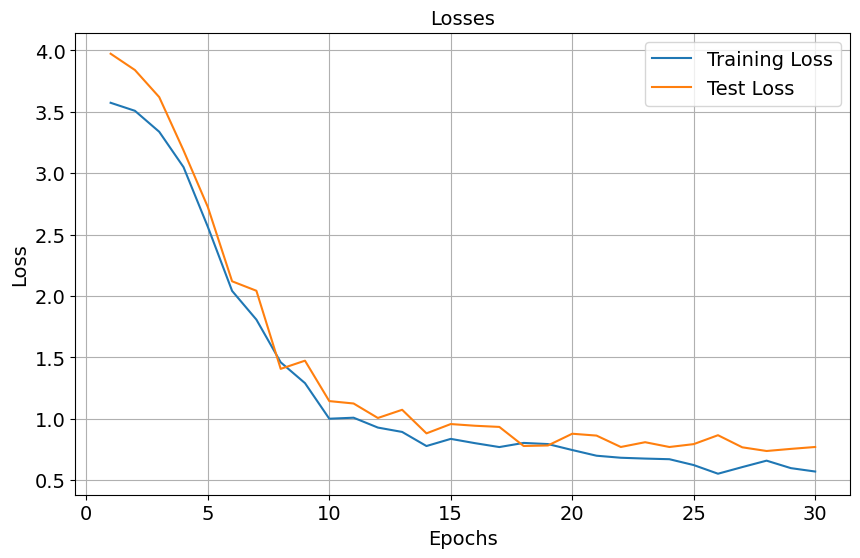

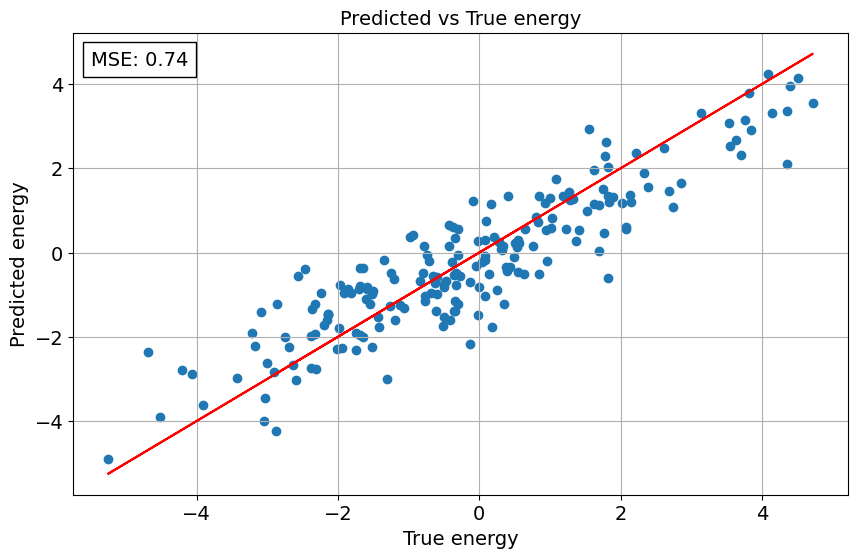

--------------------------------------------




In [22]:
for n_dimensions in list_dimensions:
    for periodic in list_periodic:

        # create the dataset
        dataset, graphs = create_dataset(n_nodes=n_nodes, h=h, periodic=periodic, n_dimensions=n_dimensions, n_samples=n_samples)
        list_datasets.append(dataset)
        list_graphs.append(graphs)

        n_connections = len(graphs[0].edges)
        list_n_connections.append(n_connections)

        print(f"n_dimensions: {n_dimensions}, periodic: {periodic}, number of connections: {n_connections}")

        # plot the first graph
        fig = plot_graph(graphs[0])


        # split the dataset into training and test set and create the loaders
        train_loader = DataLoader(dataset[:int(0.8*n_samples)], batch_size=batch_size, shuffle=False) # shuffle not needed
        test_loader = DataLoader(dataset[int(0.8*n_samples):], batch_size=batch_size, shuffle=False)

        # copy the model from scratch
        model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

        model.to(device)

        # set the model name
        model_name = set_model_name(n_nodes, n_dimensions, h, periodic, n_samples, hidden_channels_1, hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear, lr, weight_decay, dropout,num_epochs)
        list_model_names.append(model_name)

        try:
            os.mkdir(model_name)
        except:
            pass

        # save the graph plot 
        fig.savefig(model_name + "/graph.png")

        # train the model
        train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience=patience, model_name=model_name, verbose=True, device=device)
        list_train_losses.append(train_losses)
        list_test_losses.append(test_losses)

        # save train and test losses 
        np.save(model_name + '/train_losses.npy', train_losses)
        np.save(model_name + '/test_losses.npy', test_losses)
          

        # plot the losses
        fig_losses = plot_loss(train_losses, test_losses)
        fig_losses.savefig(model_name + "/losses.png")
        list_fig_losses.append(fig_losses)

        # test the trained model
        fig, mse = test_trained_model(model_name, test_loader, device=device)
        fig.savefig(model_name + "/test.png")
        list_fig_tests.append(fig)

        # store the mse
        list_mse.append(mse)

        print(44 * '-')
        print("\n")

        folder_name = f"n_nodes_{n_nodes}_n_dimensions_{n_dimensions}"
        try: os.mkdir(folder_name)
        except: pass

        # move the files to the folder
        os.system(f"mv {model_name} {folder_name}")
                     

        